In [25]:
import s3fs
import pandas as pd
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "jhajjar"
FILE_PATH_S3 = f"{MY_BUCKET}/Diffusion/post_processed_listings.csv"
with fs.open(FILE_PATH_S3, "r") as file_in:
    listings = pd.read_csv(file_in)

listings

,id,Type,Nb_chambre,loc,surface,prix
0,apimo-85473173,Appartement,1,Châtelet,29,364000
1,hektor-Les-4-Quartiers-383,Appartement,1,Châtelet,23,301000
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,Palais Royal,106,2490000
3,ag754594-448898324,Studio,1,Saint-Germain,27,365000
4,keller-williams-1-34_1_53-180645,Appartement,2,Vendôme,67,1190000
...,...,...,...,...,...,...
8825,apimo-6951400,Appartement,4,Plaine,89,599000
8826,apimo-6810785,Appartement,2,Gambetta,40,302000
8827,immo-facile-49166437,Appartement,3,Père Lachaise,67,769000
8828,immo-facile-48762452,Appartement,3,Télégraphe,57,519000


Le dataframe issu du scraping comporte 8830 entrées et 6 variables.\
La variable "id" correspond à l'identifiant unique que le site donne à chaque annonce. Il est souvent composé du nom de l'agence immobilière et d'une suite de nombres.\
La variable "Type" décrit le type du bien immobilier : appartement, maison, studio, hôtel, loft/atelier/surface.\
la variable "Nb_chambre" mesure le nombre de pièces dans le logement. Par "pièces" on entend une pièce principal comme une chambre, un salon par exemple. (la cuisine / salle de bains / toilettes / couloirs / entrée n'étant pas comptés).\
La variable "loc" indique la localisation du logement. Il ne s'agit pas d'une dénomination officielle mais de "sous-quartiers" arbitraires définis par un organisme nommé "Kelquartier", offrant des services d'informations aux plateformes immobilières.\
La variable "surface" est la superficie en mètre carré (loi Carrez) du logement. Finalement, la variable "prix" contient le prix en euros listé sur le site Bienici du bien immobilier en question.

Pour le moment nous enlevons la colonne "id" et la colonne "loc" (qui sera traitée dans une seconde partie). De plus, nous créons une colonne prix/surface (i.e. le prix au mètre carré) qui sera notre variable objective à estimer. De plus, à des fins de comparaison, analyser simplement le prix n'a pas vraiment de sens sans prendre en compte la surface du bien.

In [26]:
listings.dropna(inplace=True)
listings["prix/surface"] = listings["prix"] / listings["surface"]

Afin de mieux appréhender notre dataframe, nous utilisons la fonction describe() de pandas. 

In [27]:
description_listings = listings.describe()
description_formattée = description_listings.map(lambda x: f"{x:.2f}")  # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
description_formattée

,Nb_chambre,surface,prix,prix/surface
count,8830.00,8830.00,8830.00,8830.00
mean,2.88,68.40,792218.24,11013.54
std,1.86,53.17,878956.65,3540.78
min,1.00,4.00,22000.00,545.45
25%,2.00,33.00,330000.00,8950.00
50%,3.00,54.00,549040.00,10416.67
75%,4.00,87.00,900000.00,12307.69
max,90.00,699.00,20550000.00,52500.00


Avant d'interpréter les données, il est évident que plusieurs données résultent d'une anomalie/erreur de listing sur le site. En effet, une propriété contiendrait 90 pièces ce qui est impossible, surtout à Paris. Nous supprimons la ligne associée à cette erreur. De même le prix minimum de 22 0000 euros parait impossible pour les types de biens que nous avons retenu. Similairement, un prix par m2 de 545.54 n'est pas cohérent avec le marché parisien. 

In [28]:
listings = listings.drop(index = listings['Nb_chambre'].idxmax())
listings = listings.drop(index = listings['prix'].idxmin())
listings = listings.drop(index = listings['prix/surface'].idxmin())

In [29]:
description_listings = listings.describe()
description_écrite = description_listings.map(lambda x: f"{x:.0f}")  # écriture non scientifique et arrondi à l'unité pour améliorer la clarté.
description_formattée = description_listings.map(lambda x: f"{x:.2f}") # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
print(f"Le logement médian à Paris fait {description_écrite.loc['50%','surface']} m2, comporte {description_écrite.loc['50%','Nb_chambre']} pièces et coûte {description_écrite.loc['50%','prix']}€ soit {description_écrite.loc['50%','prix/surface']}€ au m2")
description_formattée

Le logement médian à Paris fait 54 m2, comporte 3 pièces et coûte 549080€ soit 10417€ au m2


,Nb_chambre,surface,prix,prix/surface
count,8827.00,8827.00,8827.00,8827.00
mean,2.87,68.39,792244.83,11014.60
std,1.61,53.15,878944.65,3536.00
min,1.00,4.00,22000.00,956.52
25%,2.00,33.00,330000.00,8950.00
50%,3.00,54.00,549080.00,10416.67
75%,4.00,87.00,900000.00,12307.69
max,17.00,699.00,20550000.00,52500.00


Nous avons 8829 données, une taille convenable pour pouvoir étudier les comportements statistiques asymptotiques et disposer d'une certaine représentativité du marché immobilier parisien.

Le nombre de pièces médian (3) et moyen (2.875) sont proches, ainsi, la distribution est centré autour de trois pièces. Un immeuble représentatif parisien dispose (intuitivement) de deux chambres et un salon.

La surface moyenne et médiane sont quant à elles significativement éloignées. L'écart indique une distribution asymétrique vers la droite, quelques biens tirant la moyenne à la hausse. En effet un plancher minimal s'applique pour un bien immobilier (le minimum étant ici de 4 m2) tandis que le plafond peut être bien plus élevé (ici quasiment 700 m2 au maximum). D'un côte les studettes/locaux sont nombreux mais de l'autre les grands appartements haussmanniens et l'immobilier de luxe compensent largement.

Le même raisonnement peut être appliqué pour le prix où l'on observe un écart de quasiment 250 000 euros à la hausse ce qui indique que la distribution est fortement asymétrique vers la droite. On observe un écart type encore plus élevé que la moyenne qui dévoile une variabilité très importante dans les données. le prix au m2 (prix/surface) étant une fonction du prix, hérite de cette distribution asymétrique bien que dans une plus faible mesure.

Nous avons donc des distributions asymétriques à droite caractéristiques du marché immobilier parisien et que l'on retrouve dans d'autres centres économiques européens (comme Londres, Milan, Luxembourg, Munich, Genève).

 Afin de diminuer l'importance des valeurs extrêmes nous utilisons une transformation logarithmique pour le prix.

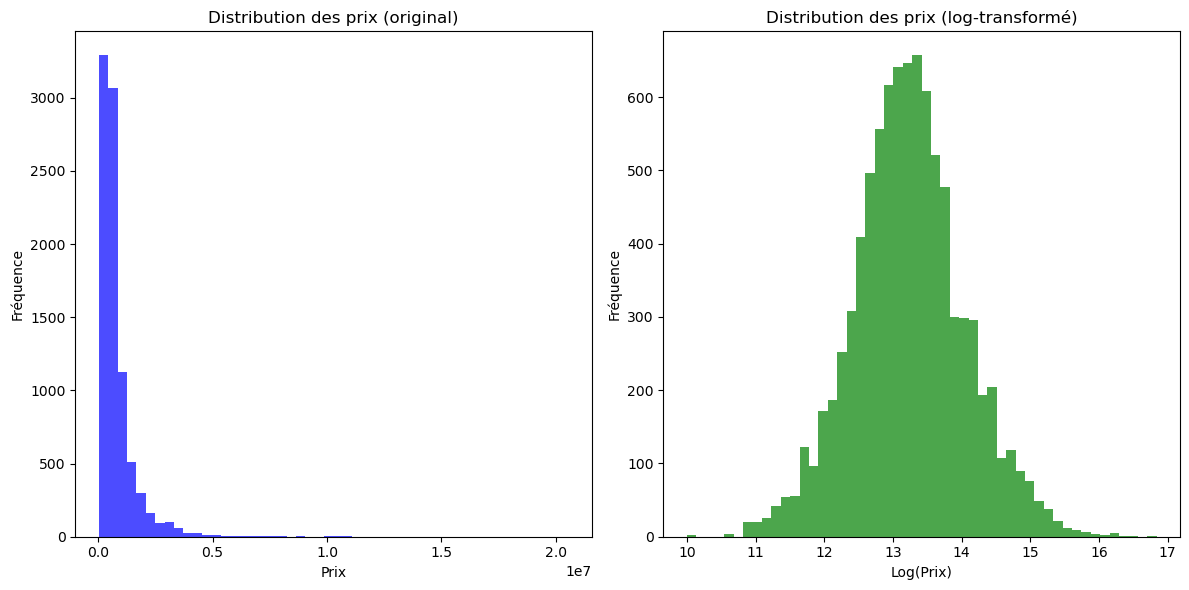

In [30]:
import numpy as np
import matplotlib.pyplot as plt
listings['log(prix)'] = np.log(listings['prix'])


# Histogramme avant transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Graphique 1
plt.hist(listings['prix'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution des prix (original)')
plt.xlabel('Prix')
plt.ylabel('Fréquence')

# Histogramme après transformation
plt.subplot(1, 2, 2)  # Graphique 2
plt.hist(listings['log(prix)'], bins=50, alpha=0.7, color='green')
plt.title('Distribution des prix (log-transformé)')
plt.xlabel('Log(Prix)')
plt.ylabel('Fréquence')


plt.tight_layout()
plt.show()
listings = listings.drop('prix', axis=1)


la log normalisation nous permet de passer d'une distribution fortement asymétrique à une distribution proche d'une gaussienne.

Procédons maintenant à l'analyse descriptive graphique de nos différentes variables.
Pour la variable surface, examinons la distribution du type de bien immobilier.

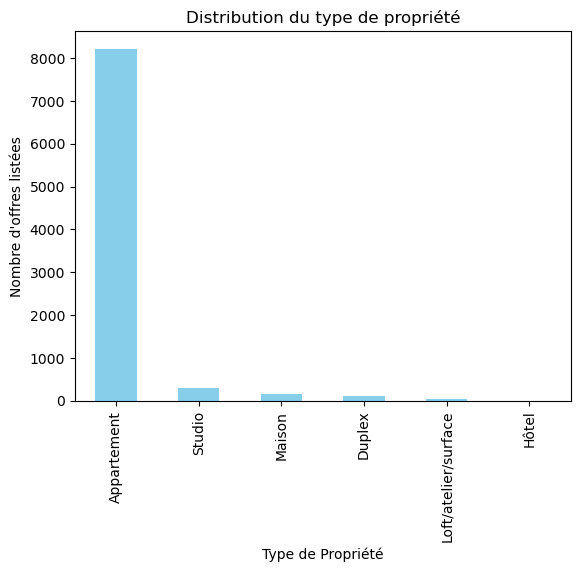

In [31]:
nombre_de_types = listings['Type'].value_counts()
nombre_de_types.plot(kind='bar', color='skyblue')
plt.title('Distribution du type de propriété')
plt.xlabel('Type de Propriété')
plt.ylabel("Nombre d'offres listées")
plt.show()

Sans surprises, la grande majorité des biens offerts sont des appartements, héritages des travaux dirigés par le Baron Haussmann entre 1853 et 1870.  
Cependant les annonces étant remplies par des agences, elles sont sujettes à erreur, surtout pour la catégorisation des biens. Par exemple, pour les petites surfaces, on trouve un certain nombre de studios qui sont catégorisés en tant qu'appartements et inversement. La dénomination choisie de "studio" ne respecte souvent pas la réglementation française (une surface habitable minimale de 9m, une hauteur sous plafond d'au moins 2,20 mètres, un volume habitable d'au moins 20 m3).

Pour les autres types (hors Loft/atelier/surface), intuitivement, ils devraient ajouter de la valeur aux biens. En effet, posséder une maison à Paris raisonne avec exclusivité, de même pour un duplex et dans une encore plus grande mesure pour un hôtel particulier.

Pour le(s) hôtel(s) particulier(s), on peut se demander s'il est raisonnable de le(s) conserver car on ne cherchera pas à estimer un bien de ce type et il pourrait fausser la représentativité de nos appartements.

In [32]:
listings[listings['Type'] == 'Hôtel']

,id,Type,Nb_chambre,loc,surface,prix/surface,log(prix)
829,ag751877-438736643,Hôtel,10,Notre Dame des Champs,646,15789.473684,16.137898


Il n'y a qu'un seul hôtel particulier et son prix au m2 est très élevé (bien au dessus du troisième quartile). Nous décidons de l'exclure afin de faciliter la modélisation

In [33]:
listings = listings[listings['Type'] != 'Hôtel']

In [34]:
from scipy.stats import ttest_ind


prix_maisons = listings[listings['Type'] == 'Maison']['log(prix)']
prix_duplex = listings[listings['Type'] == 'Duplex']['log(prix)']
prix_appartements = listings[listings['Type'] == 'Appartement']['log(prix)']
stat, p_value = ttest_ind(prix_maisons, prix_appartements, equal_var=False)
stat2, p_value2 = ttest_ind(prix_duplex, prix_appartements, equal_var=False)

print(f"Pour les Maisons : T-statistic: {stat}, P-value: {p_value}")
print(f"Pour les Duplex : T-statistic: {stat2}, P-value: {p_value2}")



Pour les Maisons : T-statistic: 14.746798485623708, P-value: 3.796915264011545e-31
Pour les Duplex : T-statistic: 8.861219450297183, P-value: 1.1470742214537283e-14


On observe des p.values inférieures à 1%, il y a bien une différence de prix significative entre les appartements d'un côté et les maisons et duplex de l'autre. En prenant en compte la surface des biens on observe que les moyennes sont très proches, et même, que celle des maisons est plus faible. Cela s'explique par le fait qu'un duplex ou une maison nécessite une surface plus grande ce qui, par mètre carré, compense le prix élevé.

In [35]:
prix_par_type = listings.groupby('Type')['prix/surface'].agg(['mean','median','count'])
prix_par_type


,mean,median,count
Type,,,
Appartement,11013.579473,10400.000000,8217
Duplex,11738.753709,10825.490196,112
Loft/atelier/surface,9438.025224,9486.443381,46
Maison,10952.881843,9937.759336,148
Studio,11028.215486,10666.666667,303


La question se pose maintenant sur la catégorie Loft/atelier/surface. la moyenne du prix au m2 est de 9438€ soit près de 15% plus faible que la moyenne globale des biens immobiliers. En effet, un loft désigne communément un logement aux espaces ouverts issu d'un ancien atelier/entrepôt. Ces logements sont souvent moins chers au m2 car ils sont souvent destinés à faire office de bureaux/locaux commerciaux. De plus, le coût énergétique est souvent plus élevé (en raison des espaces ouverts). Bien qu'une partie d'entre eux peuvent être considérés comme appartenant à la catégorie appartement, nous ne pouvons pas filtrés plus précisément ces biens. Nous décidons ainsi de ...
OU afin d'éviter de prendre en compte des locaux commerciaux (mal catégorisés) nous décidons de supprimer les 10% valeurs les plus faibles. En effet, pour ces biens immobiliers, le prix est plus faible mais compensé par un loyer mensuel (à l'instar d'un viager).

In [36]:
LAS_condition = listings['Type'] == "Loft/atelier/surface"
LAS_listings = listings[LAS_condition]

seuil_quantile = LAS_listings['prix/surface'].quantile(0.10)

LAS_filtre = LAS_listings[LAS_listings['prix/surface'] > seuil_quantile]

autres_listings = listings[~LAS_condition]

#listings = pd.concat([loft_filtre, autres_listings], ignore_index=True)



In [37]:

#listings = listings[listings["Nb_chambre"]<50]
#listings["prix/surface par pièce"] = listings["prix/surface"]/listings["Nb_chambre"]
#quantile_sup_psp = listings["prix/surface par pièce"].quantile(0.95)
#quantile_inf_psp = listings["prix/surface par pièce"].quantile(0.05)
#quantile_sup_ps = listings["prix/surface"].quantile(0.95)
#quantile_inf_ps = listings["prix/surface"].quantile(0.05)
#quantile_sup_p = listings["surface"].quantile(0.97)
#quantile_inf_p = listings["surface"].quantile(0.05)
#print(quantile_inf_p)
#print(quantile_sup_p)
##listings = listings[(listings["prix/surface par pièce"]>=quantile_inf_psp) & (listings["prix/surface par pièce"]>=quantile_inf_psp)]
##listings = listings[(listings["prix/surface"]>=quantile_inf_ps) & (listings["prix/surface"]>=quantile_inf_ps)]
#listings = listings[(listings["surface"]<=quantile_sup_p)]
#pd.plotting.scatter_matrix(listings)
#listings[listings["Nb_chambre"]>14]

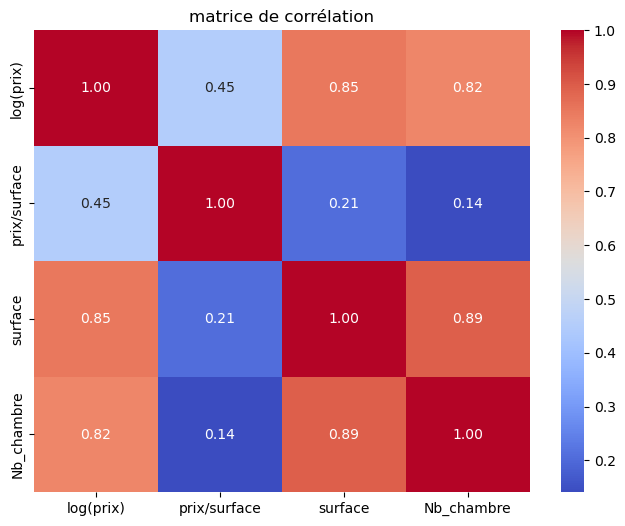

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


colonnes_numériques = ['log(prix)', 'prix/surface', 'surface', 'Nb_chambre']
df_colonnes_numeriques = listings[colonnes_numériques]
matrice_de_correlation = df_colonnes_numeriques.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(matrice_de_correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("matrice de corrélation")
plt.show()


Naturellement, le prix est corrélé positivement avec la surface du bien et son nombre de pièces. Pour le prix on observe une correlation forte, respectivement de 0.85 et 0.82. Intuitivement, si un bien est plus grand ou dispose de plus de pièces, il sera, toute chose égale par ailleurs, plus cher. Cependant, on observe que pour le prix au m2 les corrélations restent positives mais deviennent faibles (0.21 et 0.14 respectivement). Le fait que le prix au m2 soit corrélé positivement avec la surface suggère que l'augmentation du prix du bien surpasse l'augmentation de la surface. Ce phénomène peut paraître contre-intuitif pour certaines surfaces. Pour clarifier, nous analysons le coefficient de Pearson selon les quartiles.

/tmp/ipykernel_249424/3511782380.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Bracket de Surface', y='Corrélation', data=corr_df, palette='viridis', order=labels)


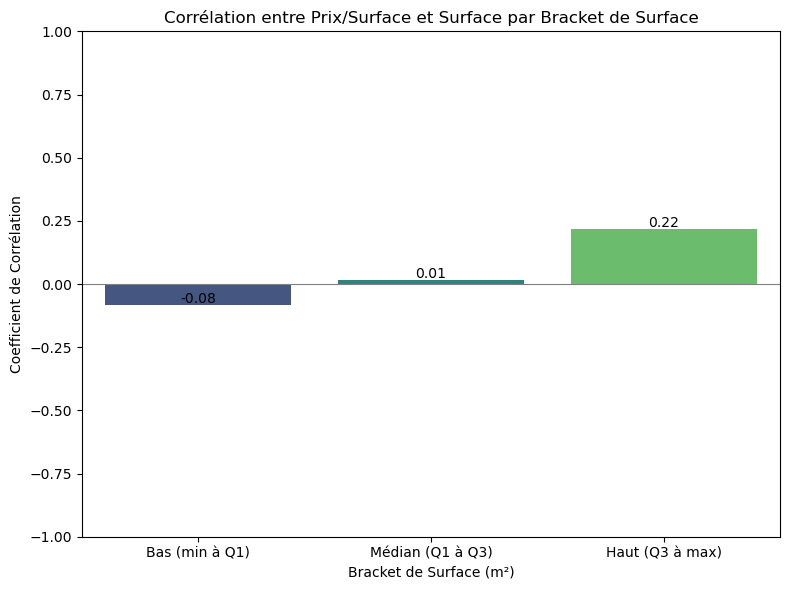

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que 'listings' est votre DataFrame existant
# Exemple d'initialisation (à remplacer par vos données réelles)
# listings = pd.read_csv('votre_fichier.csv')

# 1. Calculer les quartiles
Q1 = listings['surface'].quantile(0.25)
Q2 = listings['surface'].quantile(0.50)  # Médiane
Q3 = listings['surface'].quantile(0.75)

# 2. Définir les limites des brackets
bins = [listings['surface'].min(), Q1, Q3, listings['surface'].max()]
labels = ['Bas (min à Q1)', 'Médian (Q1 à Q3)', 'Haut (Q3 à max)']

# 3. Créer une nouvelle colonne pour les brackets de surface
listings['surface_bracket'] = pd.cut(listings['surface'], bins=bins, labels=labels, include_lowest=True)

# 4. Convertir 'surface_bracket' en type catégorique avec un ordre spécifique
listings['surface_bracket'] = listings['surface_bracket'].astype(pd.CategoricalDtype(categories=labels, ordered=True))

# 5. Gérer les données manquantes
listings_clean = listings.dropna(subset=['prix/surface', 'surface', 'surface_bracket'])

# 6. Calculer les corrélations par bracket dans l'ordre spécifié
correlation_dict = {}
for bracket in labels:
    subset = listings_clean[listings_clean['surface_bracket'] == bracket]
    if len(subset) > 1:
        corr = subset['prix/surface'].corr(subset['surface'], method='pearson')
        correlation_dict[bracket] = corr

# 7. Convertir le dictionnaire en DataFrame
corr_df = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['Corrélation'])
corr_df = corr_df.reset_index().rename(columns={'index': 'Bracket de Surface'})

# 8. Assurer l'ordre des brackets
corr_df['Bracket de Surface'] = pd.Categorical(corr_df['Bracket de Surface'], categories=labels, ordered=True)
corr_df = corr_df.sort_values('Bracket de Surface')

# 9. Tracer le diagramme en barres avec l'ordre correct
plt.figure(figsize=(8, 6))
sns.barplot(x='Bracket de Surface', y='Corrélation', data=corr_df, palette='viridis', order=labels)

# Ajouter les annotations des coefficients sur les barres
for index, row in corr_df.iterrows():
    plt.text(index, row.Corrélation + 0.01, f"{row.Corrélation:.2f}", ha='center')

# Personnaliser le graphique
plt.title('Corrélation entre Prix/Surface et Surface par Bracket de Surface')
plt.ylim(-1, 1)
plt.ylabel('Coefficient de Corrélation')
plt.xlabel('Bracket de Surface (m²)')
plt.axhline(0, color='grey', linewidth=0.8)
plt.tight_layout()
plt.show()

Toute chose égales par ailleurs, ce résultat souligne la diversité des segments du marché parisien. Les grandes surfaces étant souvent destinés à des familles dont le budget est plus élevé, ceux-ci valorisent d'avantage la qualité du bien que son prix au m2. Pour les plus petits, le prix au m2 est initialement élevé car ils sont souvent des biens d'investissements (comme un studio ou appartement étudiant), ainsi, augmenter la surface n'apporte pas de valeur substantielle au bien. Pour les biens médians, souvent recherchés par de jeunes familles avec un budget plus limité, le prix au m2 est une caractéristique clé du bien.

Analyse graphique des outliers : 

array([[<Axes: xlabel='Nb_chambre', ylabel='Nb_chambre'>,
        <Axes: xlabel='surface', ylabel='Nb_chambre'>,
        <Axes: xlabel='prix/surface', ylabel='Nb_chambre'>,
        <Axes: xlabel='log(prix)', ylabel='Nb_chambre'>],
       [<Axes: xlabel='Nb_chambre', ylabel='surface'>,
        <Axes: xlabel='surface', ylabel='surface'>,
        <Axes: xlabel='prix/surface', ylabel='surface'>,
        <Axes: xlabel='log(prix)', ylabel='surface'>],
       [<Axes: xlabel='Nb_chambre', ylabel='prix/surface'>,
        <Axes: xlabel='surface', ylabel='prix/surface'>,
        <Axes: xlabel='prix/surface', ylabel='prix/surface'>,
        <Axes: xlabel='log(prix)', ylabel='prix/surface'>],
       [<Axes: xlabel='Nb_chambre', ylabel='log(prix)'>,
        <Axes: xlabel='surface', ylabel='log(prix)'>,
        <Axes: xlabel='prix/surface', ylabel='log(prix)'>,
        <Axes: xlabel='log(prix)', ylabel='log(prix)'>]], dtype=object)

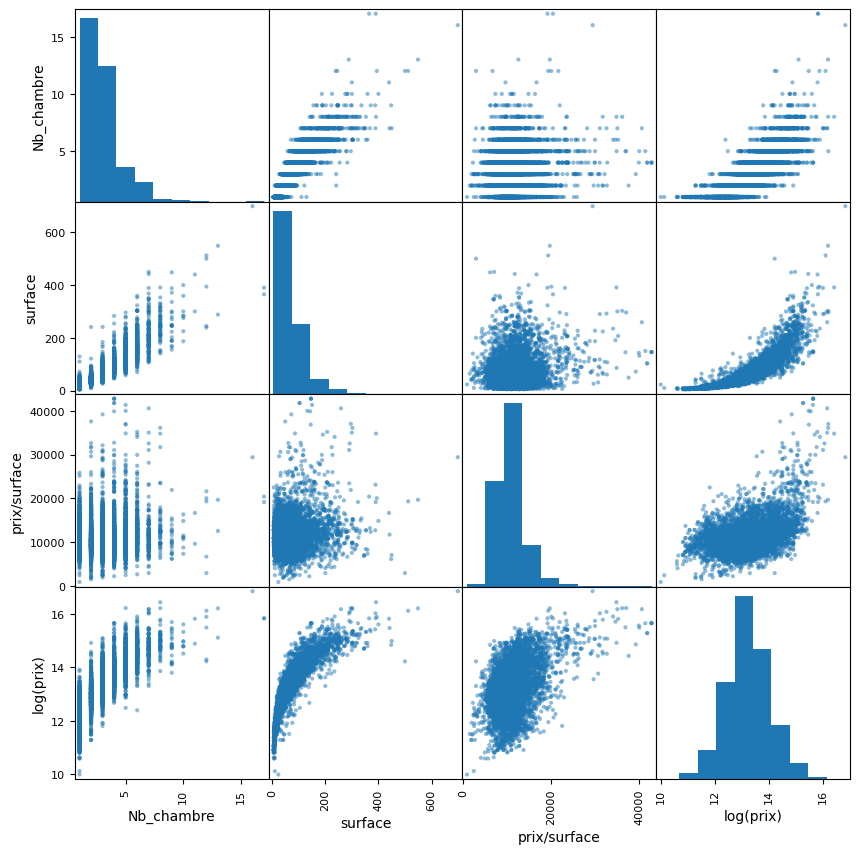

In [45]:
listings.dropna(inplace=True)

pd.plotting.scatter_matrix(listings,figsize=(10, 10))


sur ce graphique on retrouve les différentes conclusions précédemment présentées. Nous voyons en diagonale les distributions plus ou moins asymétriques. De plus on retrouve à la dernière ligne les corrélations positives du log(prix) aux pièces et surface et les corrélations plus flous du prix au m2 à l'avant dernière ligne.
Ce graphique nous permet d'identifier les points extrêmes et de juger, au cas par cas, la pertinence de les conserver dans le cadre de notre modélisation.

Premier outlier : un logement avec un prix au m2 très élevé pour son nombre de pièces et sa surface.

In [41]:
listings.loc[listings["prix/surface"] > 50000]

,id,Type,Nb_chambre,loc,surface,prix/surface,log(prix),surface_bracket
1231,apimo-7012481,Appartement,6,Triangle d'Or,150,52500.0,15.879204,Haut (Q3 à max)


Il s'agit donc d'un appartement à 52500€ le m2 ce qui est près de 5 fois plus que la moyenne. Cependant, cela pourrait en partie s'expliquer par le sous-quartier exclusif du "Triangle d'Or", terme caractérisant une zone géographique prestigieuse et haut de gamme dans plusieurs villes françaises. entres autres, à Paris, le Triangle d'Or est délimité par les avenues Montaigne, des Champs-Élysées et George-V. Comparons alors ce prix pharamineux aux autres logements offerts dans le Triangle d'Or

In [42]:
listings.groupby('loc')['prix/surface'].mean()["Triangle d'Or"]

np.float64(21593.131878107473)

La propriété a un prix par m2 deux fois plus élevé que la moyenne du quartier qui est elle même déjà exceptionnellement haute. afin de négliger l'effet inflationniste et non représentatif de ce bien sur notre modèle, nous décidons de supprimer cette offre.   

In [44]:
listings = listings.drop(index = listings['prix/surface'].idxmax())

Une autre propriété a une surface très élevée (600 m2) pour le prix maximum sur le listing de Paris mais un prix au m2 plus raisonnable.